# Introduction to Portfolio Construction and Analysis with Python
EDHEC Business School  
https://www.coursera.org/learn/introduction-portfolio-construction-python


## Introduction to Constant Proportion Portfolio Insurance (CPPI)

- dynamic allocation strategies between risky and safe assets that allow you to get downside protection and upside potential at the same time
- allocate to a risky asset in multiple M of the difference between your asset value and a given floor which by assumption is something that you want to avoid at all costs
- also mean one will allocate 0 weight to a risky asset when the asset value is at the floor value
- Gap risk is the risk of breaching the floor because of discrete trading in CPPI strategy.  Gap risk will materialize if you're not trading sufficiently frequently.  
- calibrate the multiplier as a function of the maximum potential loss within a given trading interval to manage gap risk

### For example:
- Asset Value = 100
- Floor Value = 80
- Multiplier = 3
- Invest in Risk Asset = 3 x (100-80) = 60
- Invest in Safe Asset = 40
- Rebalance every month


## Introducing Max DD constraints
Suitable extensions can accommodate the presence of maximum drawdown contraints

### First Extension - Maximum Drawdown Floor
- **Maximum Drawdown Floor**: Floor value as determined by the maximum drawdown over the rebalancing period
- Need to track the maximum value of the asset value of all time
- Asset value must be greater than alpha (eg: 80%) of the maximum value and protecting 1-alpha (20%) of maximum drawdown.


### Second Extension - Capping Wealth Level
- Protecting downside has an opportunity cost
- Giving up some of the upside above a threshold will achieve opportunity gain and this opportunity gain will cover some or all of the opportunity cost from downside protection.
- Setting a Threshold (T) between Floor (F) and Cap(C) which is average value between F and the C.
- if the asset value is between the F and T, the allocation to risky asset should be the multiplier times your asset value minus the floor.
- if asset value is anywhere between T and C, you are going to allocate a multiplier again times now cap value minus asset value
- slowing down on the way down and you're slowing down on the way up


## Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

In [1]:
import sys  
sys.path.append('../src') 
from edhec_risk_kit import *

import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt

DATA_FOLDER = '../data/'

%matplotlib inline

# data

In [2]:
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

Algorithm to dynamically allocate between a risky asset and a safe asset with the goal of making sure that that combined portfolio that consists of some allocation to the risky asset and some allocation to the safe asset does not violate a floor constraint, does not go below a certain number.

### Risky Asset

In [3]:
risky_r = ind_return['2000':][['Steel','Fin','Beer']]

In [4]:
risky_r.shape

(228, 3)

### Safe Asset

In [5]:
safe_r = pd.DataFrame().reindex_like(risky_r)  ## To create the same shape as the risky asset
safe_r[:] = 0.03/12

In [6]:
safe_r.shape

(228, 3)

In [7]:
600 * (1+safe_r.iloc[0])

Steel    601.5
Fin      601.5
Beer     601.5
Name: 2000-01, dtype: float64

### Algorithm Summary
1. Setting a start asset value and floor
2. Cushion - (Asset Value minus Floor Value)
3. Compute an Allocation to Safe and Risky Assets --> m * risk budget
4. Recompute the Asset Value based on the returns

In [8]:
start = 1000
floor = 0.8

In [9]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start * floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value) / account_value ## Risk Budget
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    
    ## update the account value for this time step
    account_value = risky_alloc * (1+risky_r.iloc[step]) + safe_alloc * (1+safe_r.iloc[step])
    
    ## save the values so I can look at the history and plot it etc
    cushion_history.iloc[step] = cushion    
    risky_w_history.iloc[step] = risky_w    
    account_history.iloc[step] = account_value

Account history if one had run CPPI on respective industry as risky asset

In [10]:
account_history

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489
...,...,...,...
2018-08,1078.784329,2461.732061,4155.508933
2018-09,1073.786842,2414.220632,4163.404400
2018-10,979.057951,2282.645608,4098.038951
2018-11,964.047446,2348.614066,4335.315406


### Risky Cumulative Wealth 
- assuming 100% in risky asset
- for comparison with CPPI strategy

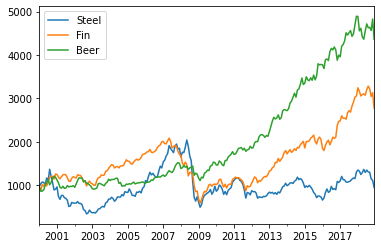

In [11]:
risky_wealth = start * (1+risky_r).cumprod()
risky_wealth.plot()
plt.show()

### 100% Risky Asset and CPPI strategy - Beer Industry
- CPPI underperforms because at the earlier years, some weights are in safe assets
- Note 100% weight in risky assets after 2009 when the market starts to pick up and the CPPI follows closely to risk asset

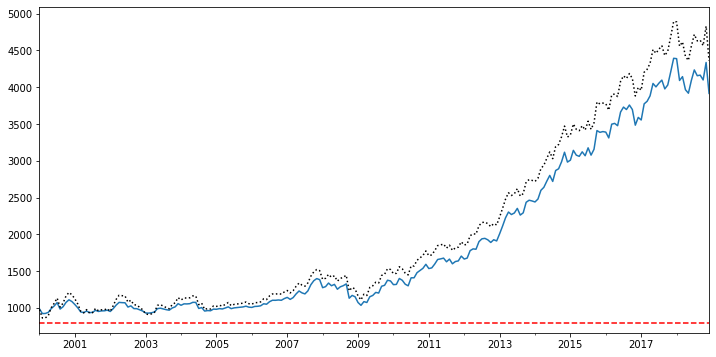

In [12]:
ax = account_history['Beer'].plot(figsize=(12,6))
risky_wealth['Beer'].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')
plt.show()

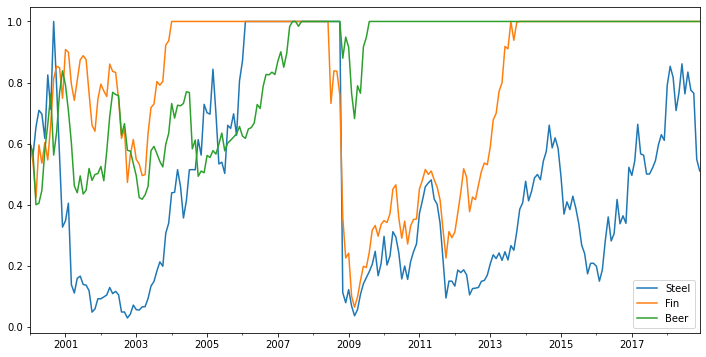

In [13]:
risky_w_history.plot(figsize=(12,6))
plt.show()

### 100% Risky Asset and CPPI strategy - Finance Industry
- Finance pierces the floor in 2009 for the 100% risky asset strategy
- The CPPI strategy there is no violation of the floor because there was so little risk budget at that point. 
- The disadvantage of that when it bounces back, you only have a small exposure to that portfolio and as a result, you don't enjoy all the upside

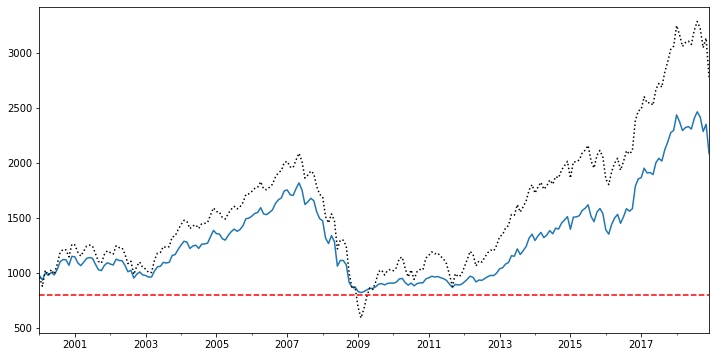

In [14]:
ind = 'Fin'
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

### 100% Risky Asset and CPPI strategy - Steel Industry
- Steel industry just tanked right away, right over there
- CPPI is far less volatile and it protects you from breaching your floor.

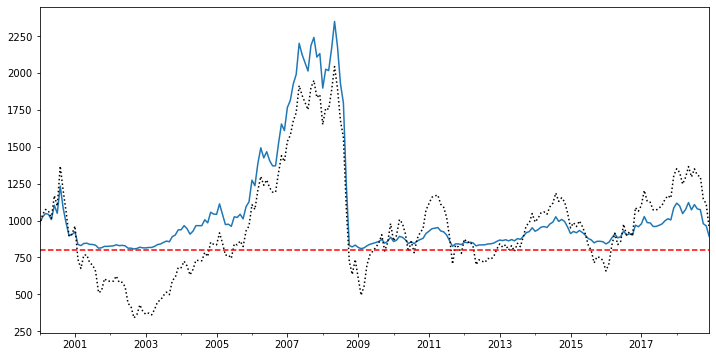

In [15]:
ind = 'Steel'
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')
plt.show()

### Summary Statistics of Risky Assets and CPPI Strategy
- Notice that it is still possible to see negative annualised returns
- CPPI strategy is meant to help manage the downside risk
- Observe improved maximum drawdown

In [16]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [17]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


### CPPI strategy using Total Market Index returns
- Observed the reduction in Max Drawdown in CPPI strategy

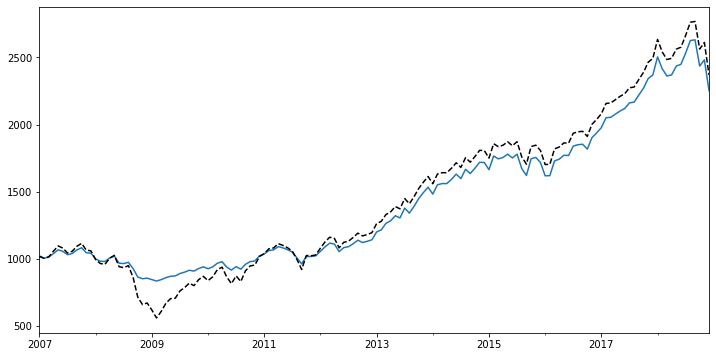

In [18]:
btr = erk.run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize=(12,6), legend=False)
btr['Risky Wealth'].plot(ax=ax, style='k--', legend=False)
plt.show()

In [19]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [20]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


### CPPI strategy with Drawdown Constraint
- Expect to see even smaller drawdowns

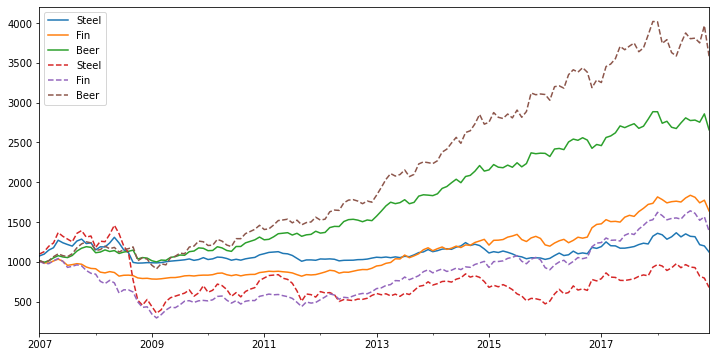

In [21]:
drawdown_contraint = 0.25
btr = erk.run_cppi(ind_return['2007':][['Steel','Fin','Beer']], drawdown = drawdown_contraint)
ax = btr['Wealth'].plot(figsize=(12,6))
btr['Risky Wealth'].plot(ax=ax, style='--')
plt.show()

In [22]:
erk.summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [23]:
erk.summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
